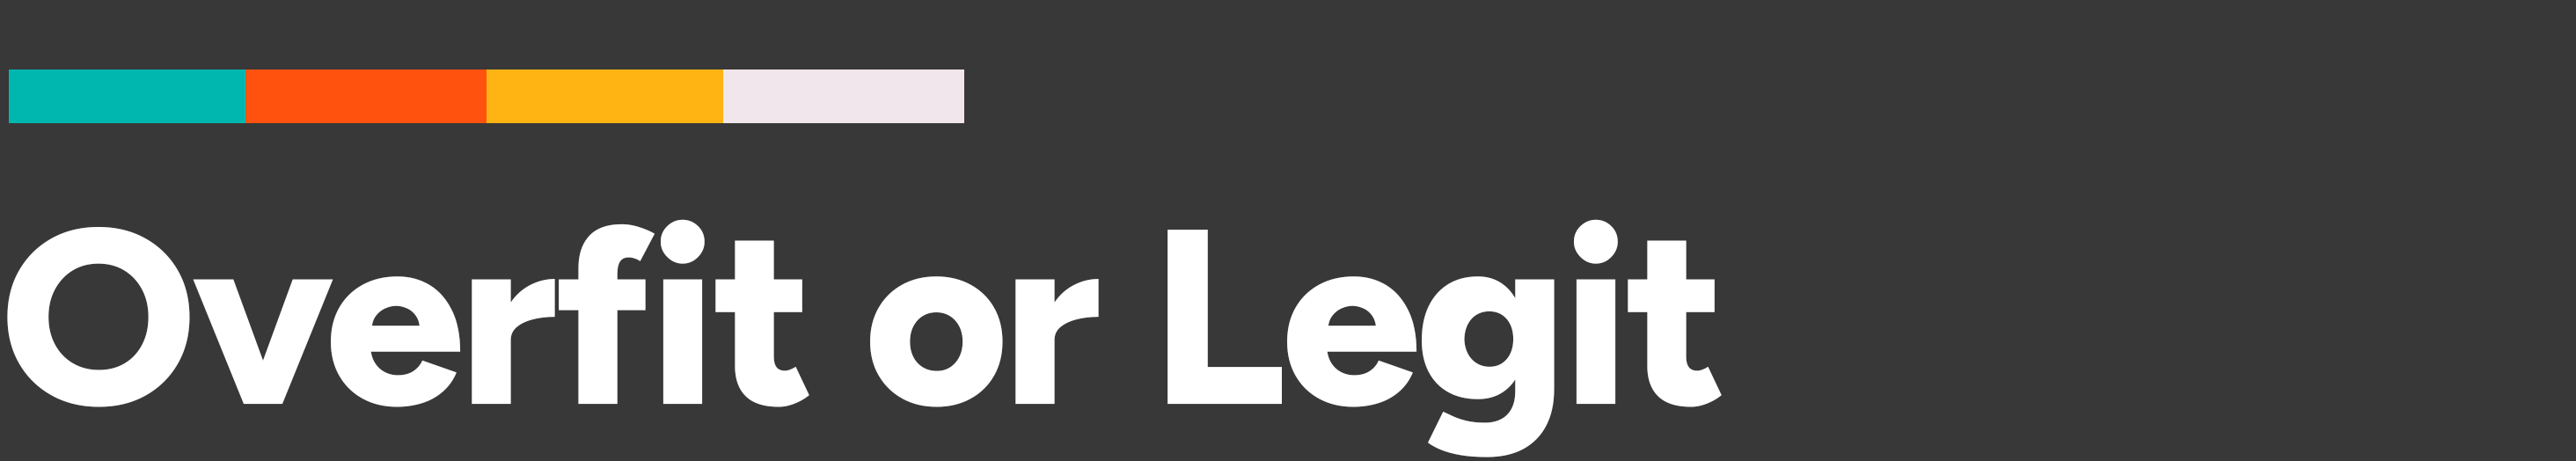

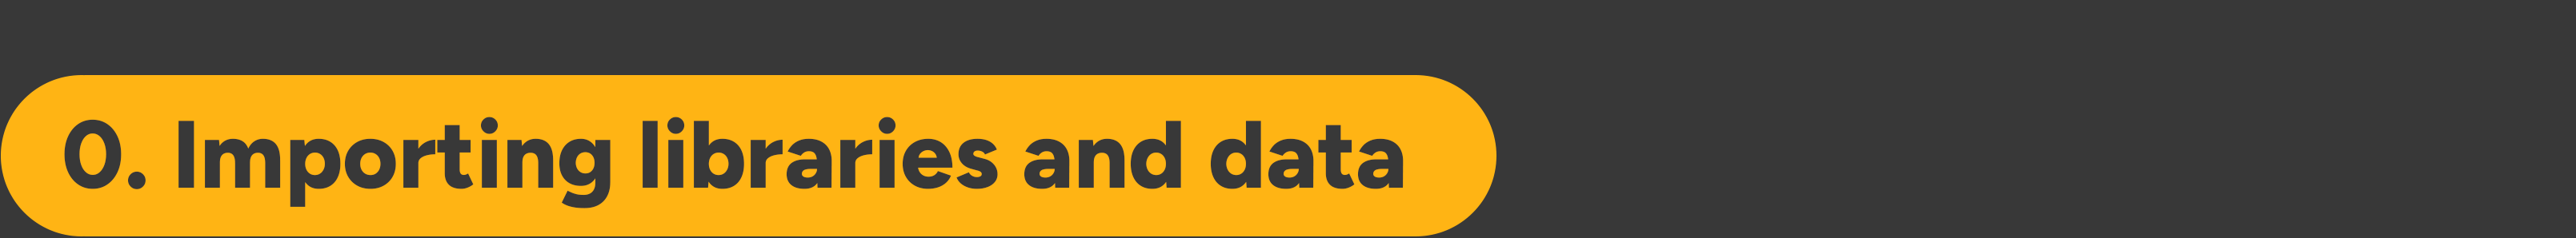

In [126]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ta
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm

sns.set(style='dark', palette='viridis')

In [127]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

forex = pd.DataFrame()
content = []
for i in files:
    df = pd.read_csv(i, index_col='Date', header=0)
    content.append(df)

forex = pd.concat(content, axis=1)
forex.dropna(inplace=True)
forex.index = pd.to_datetime(forex.index)

forex

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18 22:05:00,0.98401,99.159,93.246,123.528,1.88498,78.817,5.79210,28.950
2013-03-18 22:10:00,0.98431,99.167,93.245,123.507,1.88536,78.815,5.79153,28.947
2013-03-18 22:15:00,0.98440,99.157,93.231,123.536,1.88551,78.810,5.79213,28.956
2013-03-18 22:20:00,0.98448,99.182,93.206,123.531,1.88563,78.822,5.79259,28.970
2013-03-18 22:25:00,0.98445,99.229,93.179,123.589,1.88564,78.853,5.79234,28.963
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,0.59906,101.990,112.977,166.347,1.69644,92.828,10.86585,27.204
2024-05-07 10:10:00,0.59900,101.995,112.965,166.364,1.69645,92.822,10.86554,27.205
2024-05-07 10:15:00,0.59904,102.016,112.973,166.376,1.69645,92.828,10.86469,27.194


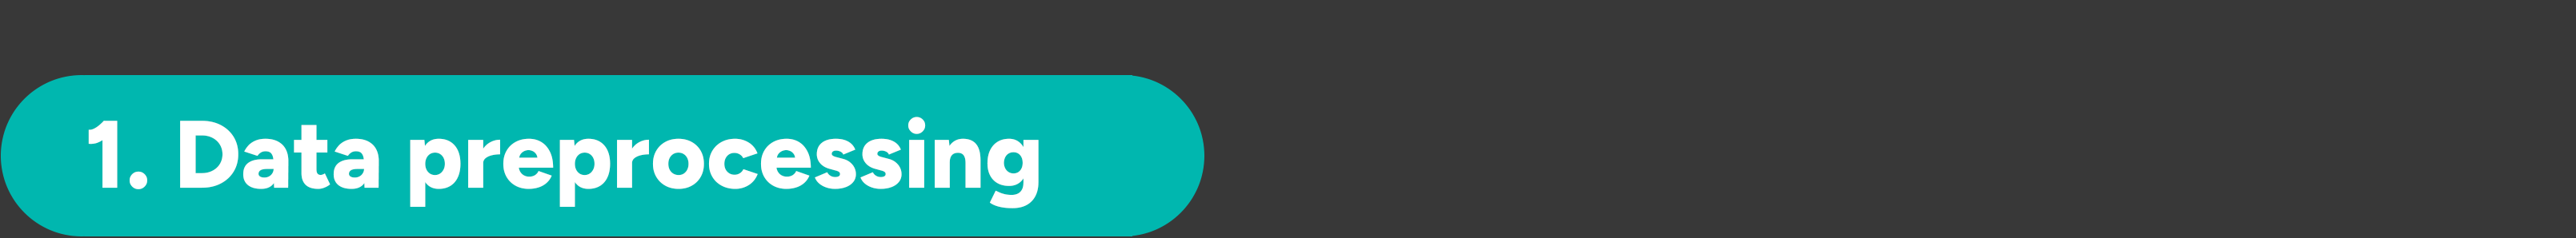

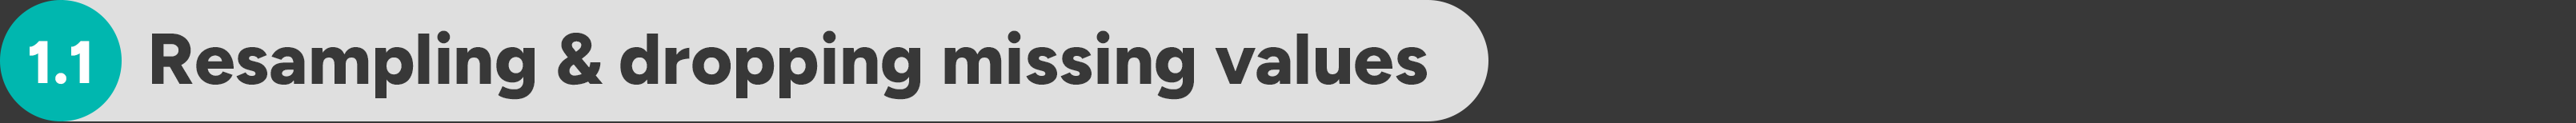

Resampling (5 min interval to daily interval) + dropping nans (for non trading days)

In [128]:
forex_daily = forex.resample('D').mean()
forex_daily.dropna(inplace = True)
forex_daily

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,0.984021,99.262391,93.292261,123.700739,1.884967,78.868826,5.790434,28.954870
2013-03-19,0.981480,98.808842,92.990419,123.070242,1.888079,78.514902,5.811537,28.906283
2013-03-20,0.981423,99.142725,93.016902,123.387845,1.890114,78.578057,5.834484,28.871717
2013-03-21,0.984902,99.279198,93.104660,123.166794,1.893798,79.167710,5.840223,29.031668
2013-03-22,0.984958,98.788456,92.445386,122.543539,1.898793,78.859048,5.823279,28.945592
...,...,...,...,...,...,...,...,...
2024-05-02,0.597146,101.196609,112.853420,165.721609,1.700319,91.842667,11.030503,26.531112
2024-05-03,0.597832,100.827510,111.892904,164.429801,1.696113,91.616701,10.913880,26.522653
2024-05-05,0.598583,101.322600,111.973850,164.920150,1.693584,92.095900,10.846253,26.559250


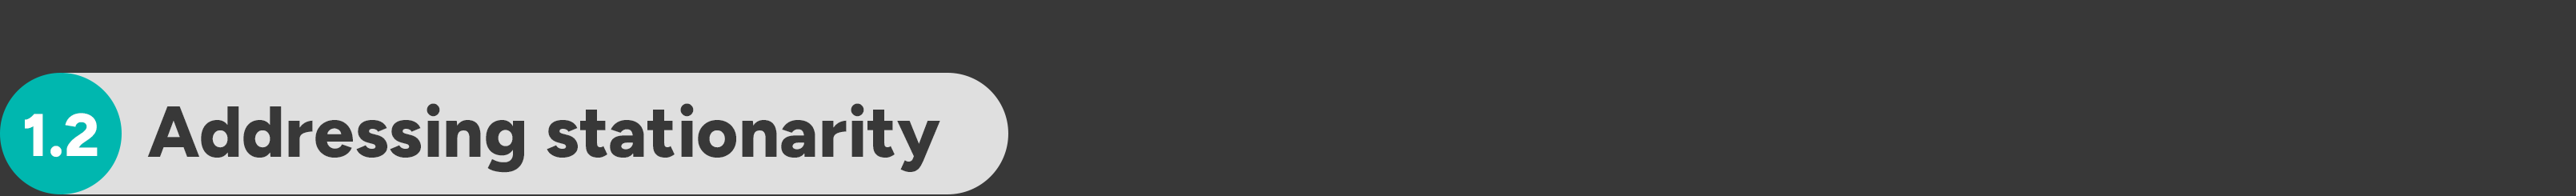

Stationarity is a necessary, non-sufficient condition for the high performance of an ML algorithm.

**PROBLEM**: there is a trade-off between stationarity and memory.
* too much differencing = stationary BUT no memory

**SOLUTION**: use fractional differencing, i.e. minimum degree of differencing, just enuf to pass adf test

Visual inspection

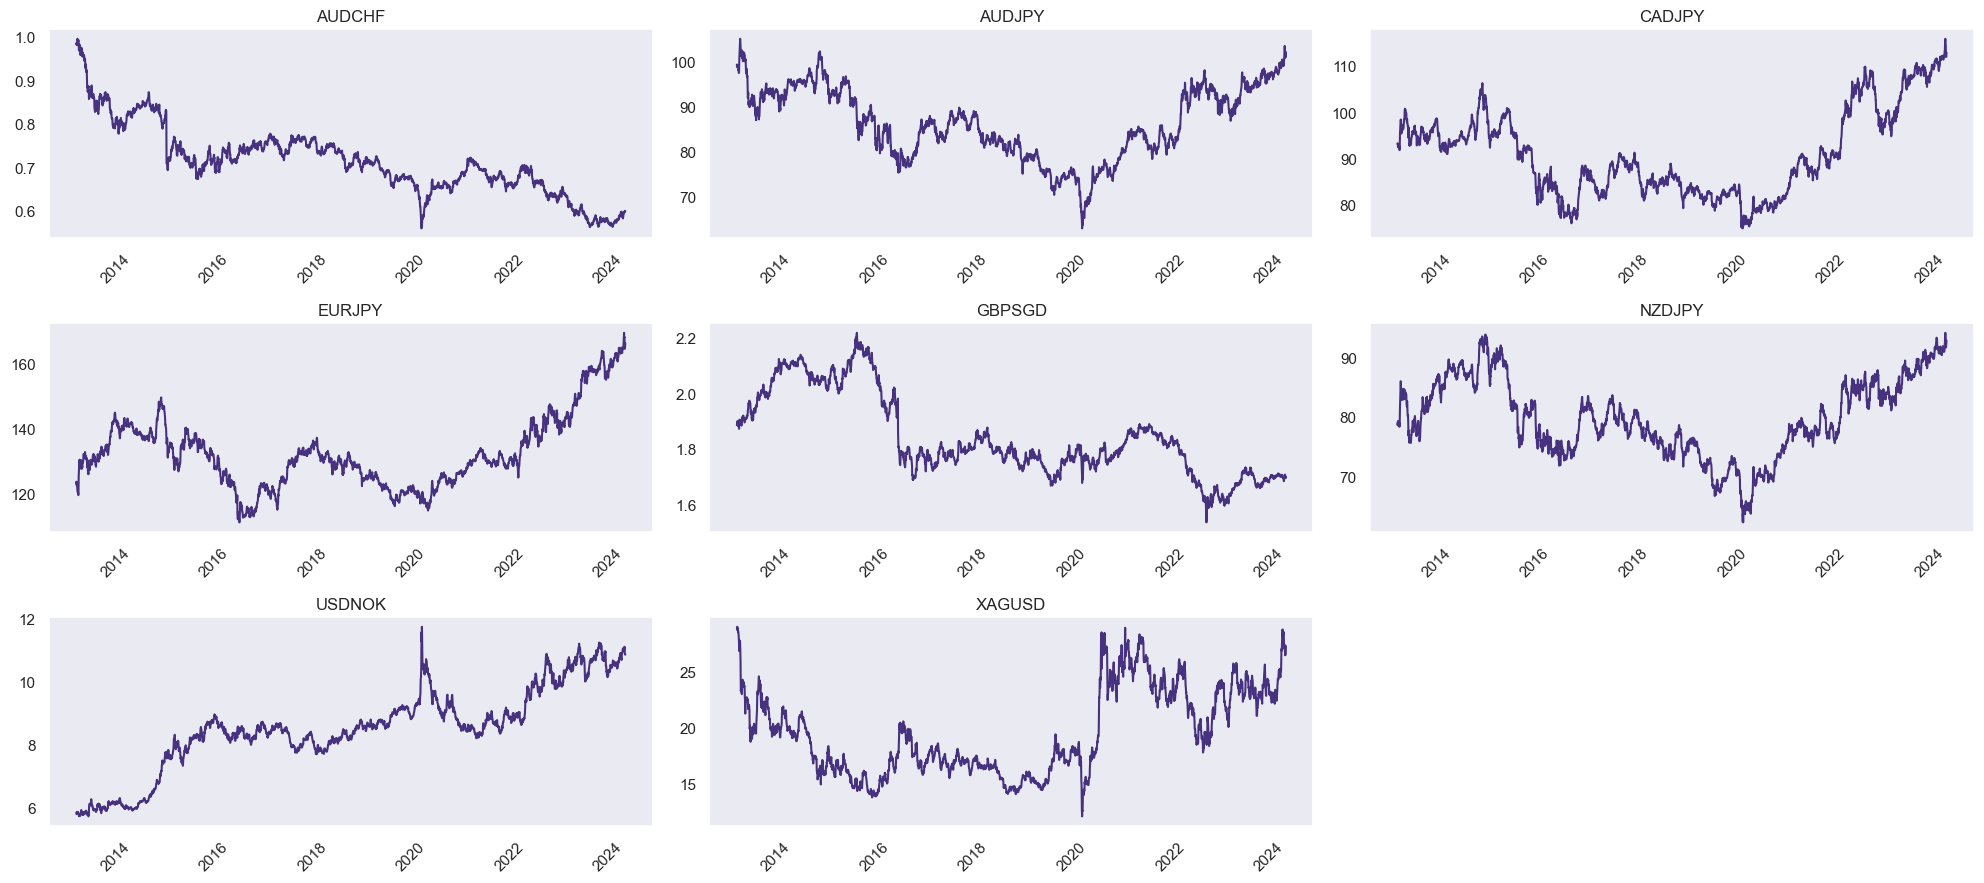

In [129]:
num_plots = len(forex_daily.columns)
nrows = (num_plots // 3) + (1 if num_plots % 3 else 0)
ncols = min(3, num_plots)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 9))

axes = axes.flatten()

for i, column in enumerate(forex_daily.columns):
    axes[i].plot(forex_daily.index, forex_daily[column])
    axes[i].set_title(column)
    axes[i].tick_params(axis = "x", rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

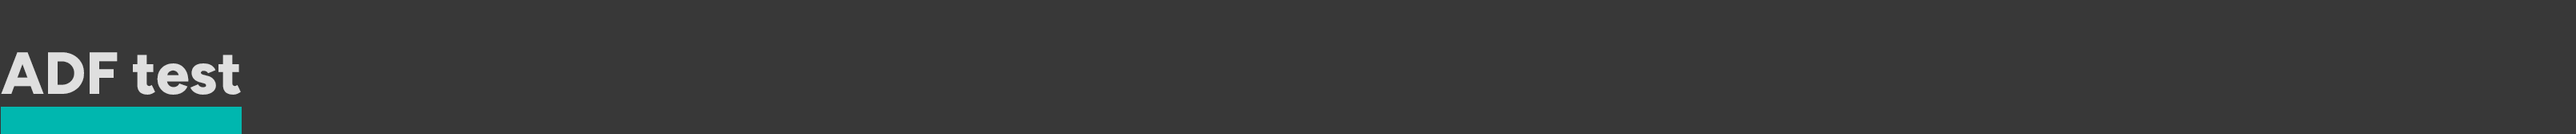

In [130]:
adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily[pair])
    adf_stat = result[0]
    p = result[1]
    adf_results.append((pair, adf_stat, p))

adf_results = pd.DataFrame(adf_results, columns = ['pair', 'adf_stat', 'p'])
display(adf_results)
print(f'\nNumber of pairs with a p-value < 0.05: {sum(adf_results.p < 0.05)} out of {len(adf_results)} pairs.')
adf_non_stationary = adf_results[adf_results["p"] < 0.05].reset_index(drop = True)
adf_non_stationary

,pair,adf_stat,p
0,AUDCHF,-3.040725,0.031262
1,AUDJPY,-1.902124,0.331063
2,CADJPY,-0.940435,0.774365
3,EURJPY,-0.570026,0.877612
4,GBPSGD,-1.360763,0.600935
5,NZDJPY,-1.763264,0.398847
6,USDNOK,-1.464127,0.551177
7,XAGUSD,-2.500256,0.115412



Number of pairs with a p-value < 0.05: 1 out of 8 pairs.


,pair,adf_stat,p
0,AUDCHF,-3.040725,0.031262


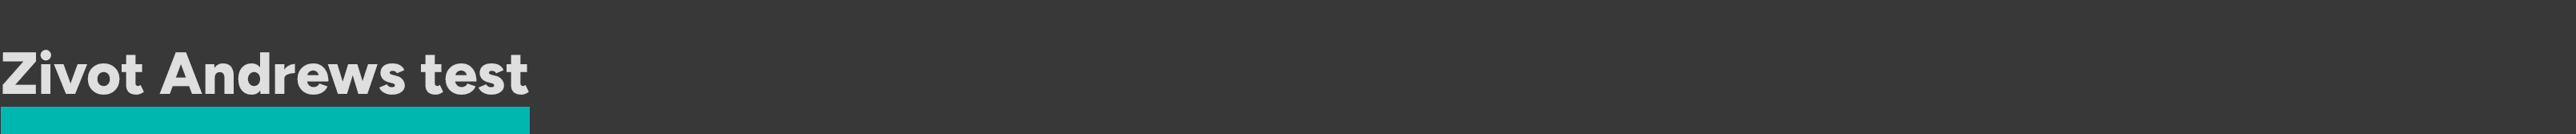

Address adf test's issue by accounting for single structural breaks

In [131]:
from arch.unitroot import ZivotAndrews

za_results = []

for pair in forex_daily.columns:
    za = ZivotAndrews(forex_daily[pair])
    p = za.pvalue
    stat = za.stat
    za_results.append((pair, stat, p))

za_results = pd.DataFrame(za_results, columns = ['pair', 'za_stat', 'p'])
display(za_results)

print(f'\nNumber of pairs with a p-value < 0.05: {sum(za_results.p < 0.05)} out of {len(za_results)} pairs.')
za_non_stationary = za_results[za_results["p"] < 0.05].reset_index(drop = True)
za_non_stationary

,pair,za_stat,p
0,AUDCHF,-4.816294,0.049369
1,AUDJPY,-3.599176,0.614633
2,CADJPY,-3.441184,0.716414
3,EURJPY,-3.298552,0.796055
4,GBPSGD,-4.579112,0.097066
5,NZDJPY,-3.492986,0.684153
6,USDNOK,-3.823301,0.463739
7,XAGUSD,-6.037815,0.000786



Number of pairs with a p-value < 0.05: 2 out of 8 pairs.


,pair,za_stat,p
0,AUDCHF,-4.816294,0.049369
1,XAGUSD,-6.037815,0.000786


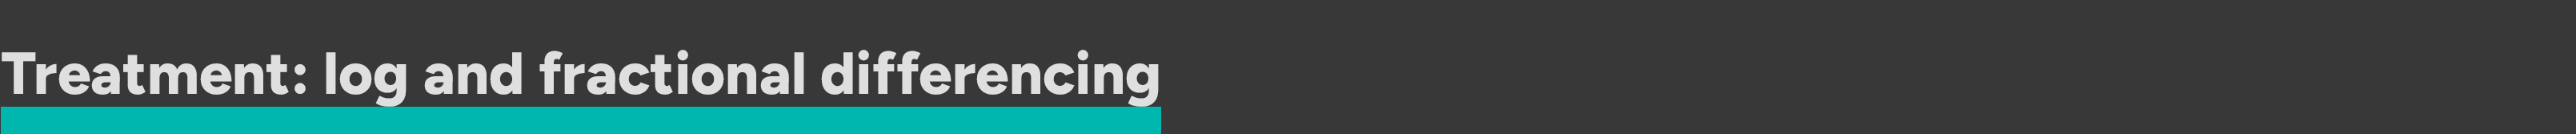

Source: textbook page 160, 161

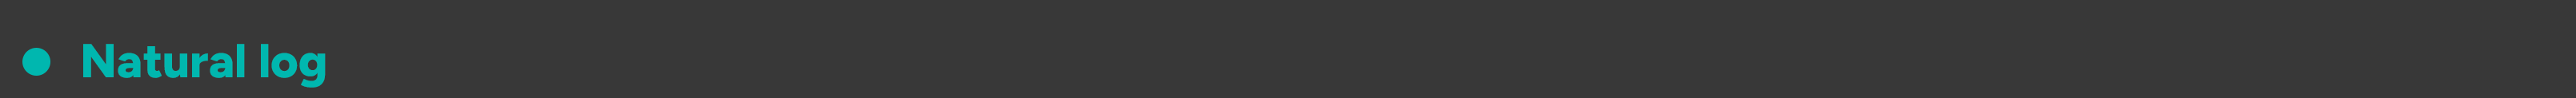

In [195]:
allres = []
for column in forex_daily.columns:
    result = adfuller(forex_daily[column])
    p_value = result[1]
    allres.append({'Column': column, 'p-value': p_value})
allres_df = pd.DataFrame(allres)
display(allres_df)
non_stationary = allres_df[allres_df['p-value'] > 0.05]
print("\nNon-stationary pairs:")
non_stationary

,Column,p-value
0,AUDCHF,0.031262
1,AUDJPY,0.331063
2,CADJPY,0.774365
3,EURJPY,0.877612
4,GBPSGD,0.600935
5,NZDJPY,0.398847
6,USDNOK,0.551177
7,XAGUSD,0.115412



Non-stationary pairs:


,Column,p-value
1,AUDJPY,0.331063
2,CADJPY,0.774365
3,EURJPY,0.877612
4,GBPSGD,0.600935
5,NZDJPY,0.398847
6,USDNOK,0.551177
7,XAGUSD,0.115412


all = pretty much non stationary -> log to stabilise a bit

In [197]:
forex_daily_log = np.log(forex_daily)
forex_daily_log.head(2)

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,-0.016108,4.597767,4.535737,4.817865,0.633911,4.367786,1.756207,3.365738
2013-03-19,-0.018693,4.593187,4.532496,4.812755,0.635560,4.363288,1.759845,3.364059


Since the values of AUDCHF is too close to zero -> negative log prices. Fix: **translation** - adding a constant to value b4 taking log.

In [202]:
a = 1 - np.min(forex_daily)
forex_daily_log = np.log(forex_daily + a)
forex_daily_log.head()

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,0.353764,4.602194,4.540447,4.821419,0.843877,4.373354,1.829510,3.380834
2013-03-19,0.351979,4.597634,4.537221,4.816327,0.845214,4.368882,1.832891,3.379179
2013-03-20,0.351938,4.600993,4.537505,4.818895,0.846088,4.369681,1.836555,3.378001
2013-03-21,0.354382,4.602362,4.538443,4.817109,0.847667,4.377116,1.837469,3.383443
2013-03-22,0.354421,4.597429,4.531371,4.812054,0.849805,4.373231,1.834767,3.380518


Checking to see if logging has stabilise the data enuf:

In [201]:
logged_adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily_log[pair])
    logged_adf_stat = result[0]
    p = result[1]
    logged_adf_results.append((pair, logged_adf_stat, p))

logged_adf_results = pd.DataFrame(logged_adf_results, columns = ['pair', 'logged_adf_stat', 'p'])
display(logged_adf_results)
print(f'\nNumber of pairs with a p-value > 0.05: {sum(logged_adf_results.p > 0.05)} out of {len(logged_adf_results)} pairs.')
logged_adf_non_stationary = logged_adf_results[logged_adf_results["p"] > 0.05].reset_index(drop = True)

,pair,logged_adf_stat,p
0,AUDCHF,-2.737852,0.067714
1,AUDJPY,-1.919301,0.323037
2,CADJPY,-1.083458,0.721624
3,EURJPY,-0.835126,0.808586
4,GBPSGD,-1.390507,0.586819
5,NZDJPY,-1.806619,0.377180
6,USDNOK,-1.687895,0.437360
7,XAGUSD,-2.593450,0.094359



Number of pairs with a p-value > 0.05: 8 out of 8 pairs.


not enuf -> frac diff (note: were usiing ADF fuller test result as a benchmark)

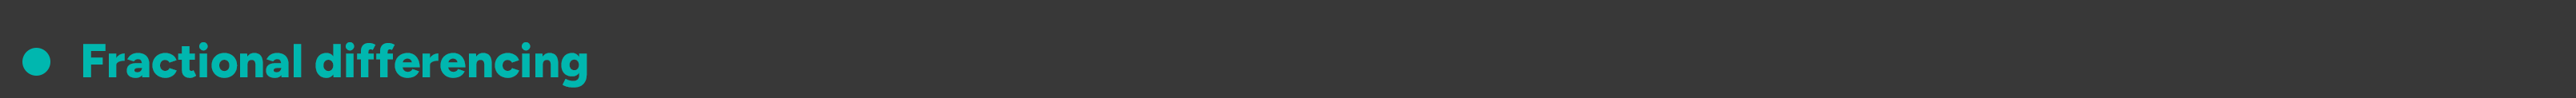

In [555]:
forex_daily_log_frdiff = forex_daily_log.copy()
fracDiff = FractionalDifferentiator()

for pair in logged_adf_non_stationary.pair.values[:]:
    forex_daily_log_frdiff[pair] = fracDiff.FitTransform(forex_daily[pair])
display(forex_daily_log_frdiff)

nan_counts = forex_daily_log_frdiff.isnull().sum()
columns_with_nans = [nan_counts[nan_counts > 0]]
print("Number of columns with NaN values:")
columns_with_nans

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-05-02,0.020757,2.600617,2.364972,3.538431,0.050444,2.012808,0.345027,0.753114
2024-05-03,0.020986,2.753611,2.240918,3.493959,0.048106,2.360093,0.251446,0.772505
2024-05-05,0.021185,3.556105,3.027098,4.941196,0.048224,3.091968,0.249423,0.839130


Number of columns with NaN values:


[AUDCHF    169
 AUDJPY    169
 CADJPY    169
 EURJPY    169
 GBPSGD    169
 NZDJPY    169
 USDNOK    169
 XAGUSD    169
 dtype: int64]

In [562]:
# check
cleaned_data = forex_daily_log_frdiff.dropna()

allres = []
for column in cleaned_data.columns:
    result = adfuller(cleaned_data[column])
    p_value = result[1]
    allres.append({'Column': column, 'p-value': p_value})

allres_df = pd.DataFrame(allres)
non_stationary = allres_df[allres_df['p-value'] > 0.05]

print("\nNon-stationary pairs:")
display(non_stationary)


Non-stationary pairs:


,Column,p-value


recommendation: plots of statistics to show structural breaks or lack therefof to determine appropriate stationarity test and change fracdiff stationarity benchmark

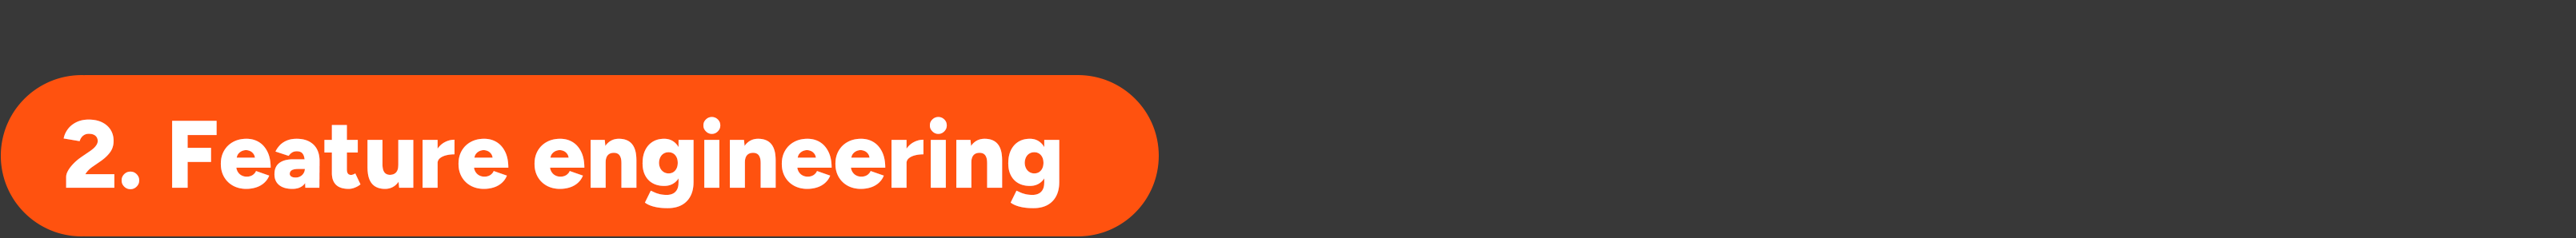

https://alphascientist.com/feature_engineering.html

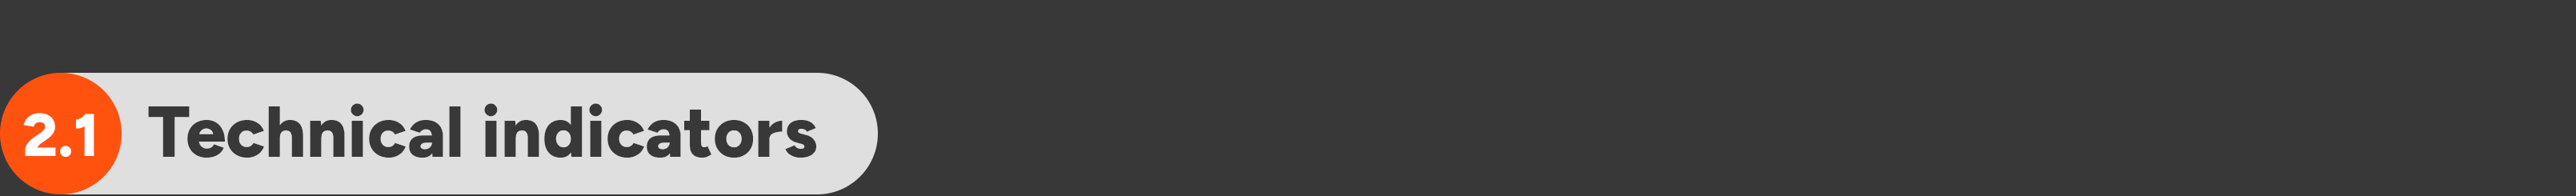

consider: spreads, changes in bid prices, changes in ask prices, differences in bid and ask volumes, volatility of bid prices, and volatility of ask prices. 

Lets just pick out AUDCHF as an example to see how the `features` df is formed for each price path.

In [563]:
# Pick out a single path to demonstrate how the features df is created
AUDCHF = forex_daily_log['AUDCHF']
features_AUDCHF = pd.DataFrame()
AUDCHF

Date
2013-03-18    0.353764
2013-03-19    0.351979
2013-03-20    0.351938
2013-03-21    0.354382
2013-03-22    0.354421
                ...   
2024-05-02    0.036857
2024-05-03    0.037517
2024-05-05    0.038241
2024-05-06    0.039296
2024-05-07    0.039265
Name: AUDCHF, Length: 3445, dtype: float64

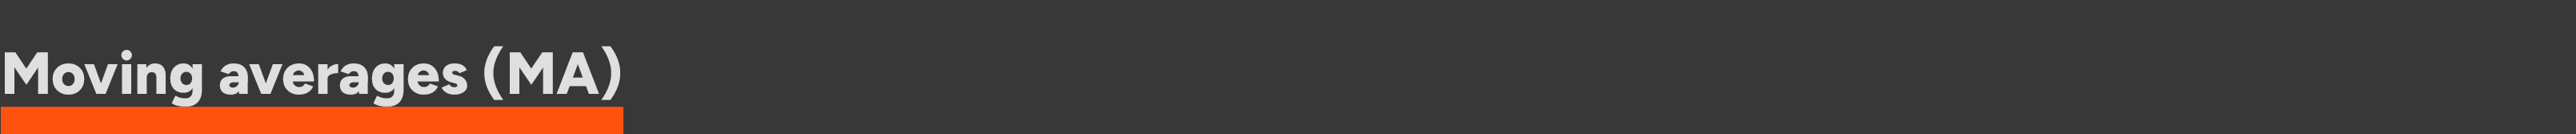

Simple moving average (sma), exponential moving average (EMA)

In [564]:
features_AUDCHF['sma_10'] = ta.trend.sma_indicator(AUDCHF, window=10)
features_AUDCHF['sma_20'] = ta.trend.sma_indicator(AUDCHF, window=20)

features_AUDCHF['ema_10'] = ta.trend.ema_indicator(AUDCHF, window=10)
features_AUDCHF['ema_20'] = ta.trend.ema_indicator(AUDCHF, window=20)

Volatility - Exponential weighted moving average (EWMA)

In [538]:
def daily_volatility_with_log_returns(
        close: pd.Series,
        span: int = 100 # determines how much weight is assigned to the previous observations in the EWMA calculation
) -> pd.Series:
    """
    Calculate the daily volatility at intraday estimation points using Exponentially Weighted Moving Average (EWMA).

    :param close: A pandas Series of daily close prices.
    :param span: The span parameter for the Exponentially Weighted Moving Average (EWMA).
    :return: A pandas Series containing daily volatilities.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: Page 44)
    """
    
    df = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    # searchsorted method returns the index of the first element in the array that is greater than the search value.
        
    df = df[df > 0] # filters out the non-positive values from the df array, ensuring that only valid indices are considered.
    df = pd.Series(close.index[df - 1], index=close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")
    # essentially its just using an alpha param that is determined by the span, then use that as kinda like a weigth 
    # param for the std method nothin 2 complicated

    return stds

In [565]:
features_AUDCHF['volatility'] = daily_volatility_with_log_returns(AUDCHF, 100)

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Consider: integrated window moving average (IWMA)

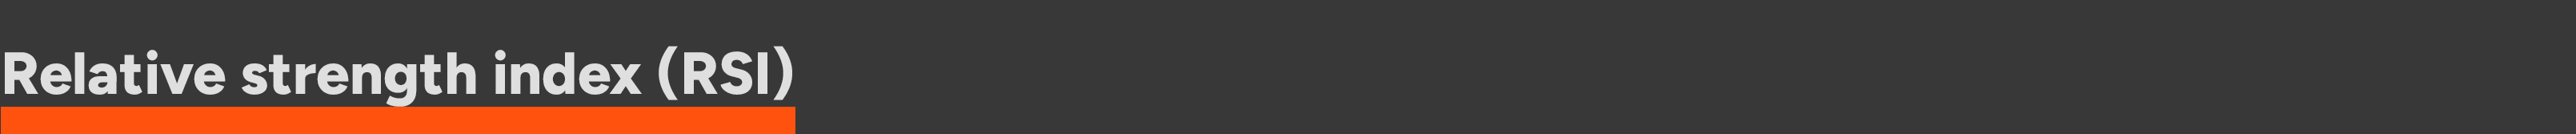

In [566]:
features_AUDCHF['rsi'] = ta.momentum.rsi(AUDCHF)
features_AUDCHF['macd'] = ta.trend.macd_diff(AUDCHF)
features_AUDCHF['bb_upper'], features_AUDCHF['bb_middle'], features_AUDCHF['bb_lower'] = \
    ta.volatility.bollinger_hband_indicator(AUDCHF), ta.volatility.bollinger_mavg(AUDCHF), \
    ta.volatility.bollinger_lband_indicator(AUDCHF)

Normalisation of features

In [567]:
features_AUDCHF

,sma_10,sma_20,ema_10,ema_20,volatility,rsi,macd,bb_upper,bb_middle,bb_lower
Date,,,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2013-03-21,NaN,NaN,NaN,NaN,0.008470,NaN,NaN,0.0,NaN,0.0
2013-03-22,NaN,NaN,NaN,NaN,0.006947,NaN,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.034355,0.031631,0.034542,0.032610,0.167000,61.991346,0.000540,0.0,0.031631,0.0
2024-05-03,0.035421,0.031691,0.035083,0.033078,0.165344,63.086686,0.000511,0.0,0.031691,0.0
2024-05-05,0.036320,0.031873,0.035657,0.033569,0.163699,64.301826,0.000495,0.0,0.031873,0.0


In [582]:
forex_daily_log_frdiff

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-05-02,0.020757,2.600617,2.364972,3.538431,0.050444,2.012808,0.345027,0.753114
2024-05-03,0.020986,2.753611,2.240918,3.493959,0.048106,2.360093,0.251446,0.772505
2024-05-05,0.021185,3.556105,3.027098,4.941196,0.048224,3.091968,0.249423,0.839130


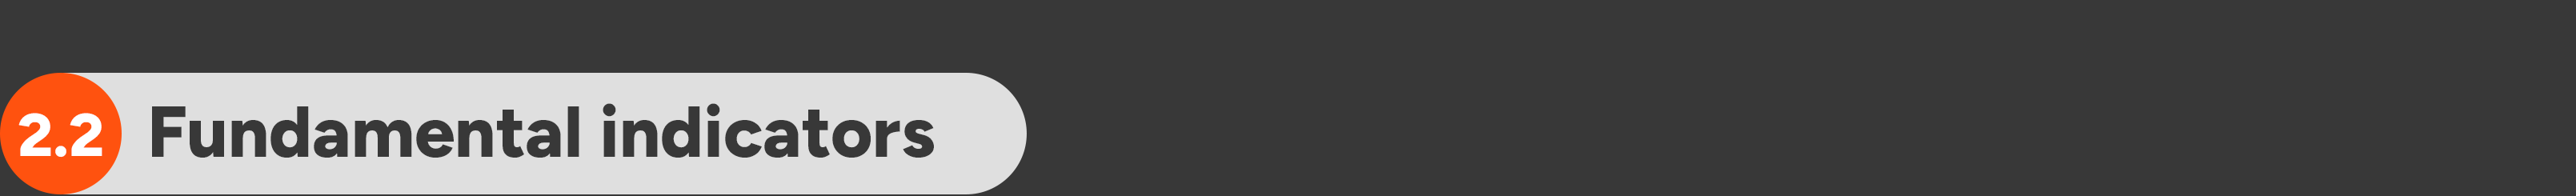

https://arxiv.org/pdf/2002.10247

Consumer Price Index (CPI) 
● Index of Industrial Production (IIP) 
● Interest Rates 
● Money Supply 
● Total Reserves 
● Stock Market Index 
● Trade (Net Exports)

news / market sentiment

https://www.epchan.com/What%20we%20learned%20from%20Kaggle%20Two-Sigma%20News%20Sentiment%20competition.pdf

Sentiment and Economic Indicators:

Interest Rates: Changes in interest rates can affect currency values.
Economic Data Releases: Reports such as GDP, employment numbers, and inflation rates can impact currency markets.
Market Sentiment Indicators: Sentiment analysis from news, social media, or trader positioning data.
Cross-Currency Relationships:

Correlations: Strength and direction of relationships between different currency pairs.
Currency Strength: Relative strength of a currency compared to others in a pair.

In [593]:
import yfinance as yf

aud_data = yf.download('AUDUSD=X', start='2013-03-18', end='2024-05-07')
chf_data = yf.download('CHFUSD=X', start='2013-03-18', end='2024-05-07')

aud_interest_rate = aud_data['Adj Close']
chf_interest_rate = chf_data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [595]:
chf_interest_rate

Date
2013-03-18    1.057753
2013-03-19    1.055743
2013-03-20    1.055264
2013-03-21    1.058649
2013-03-22    1.056859
                ...   
2024-04-30    1.098032
2024-05-01    1.087559
2024-05-02    1.091274
2024-05-03    1.099179
2024-05-06    1.103826
Name: Adj Close, Length: 2902, dtype: float64

In [605]:
start=forex_daily_log_frdiff.index[0]
end=forex_daily_log_frdiff.index[-1]
start, end

(Timestamp('2013-03-18 00:00:00'), Timestamp('2024-05-07 00:00:00'))

In [616]:
import pandas as pd
import yfinance as yf

def get_interest_data(dataframe, pair):
    interest_symbol_1 = pair[:3] + '=X'
    interest_symbol_2 = pair[3:] + '=X'
    interest_data_1 = yf.download(interest_symbol_1, start=dataframe.index[0], end=dataframe.index[-1])
    interest_data_2 = yf.download(interest_symbol_2, start=dataframe.index[0], end=dataframe.index[-1])
    interest_data_2
    return interest_data_1, interest_data_2

pair = 'AUDCHF'
interest_AUD, interest_CHF = get_interest_data(forex_daily_log_frdiff, pair)
interest_AUD.iloc[200:220]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-24,1.11950,1.1225,1.1193,1.1198,1.1198,0
2013-12-25,1.12020,1.1216,1.1184,1.1202,1.1202,0
2013-12-26,1.12170,1.1264,1.1209,1.1214,1.1214,0
2013-12-27,1.12530,1.1262,1.1200,1.1253,1.1253,0
2013-12-30,1.12940,1.1316,1.1225,1.1293,1.1293,0
2013-12-31,1.12040,1.1220,1.1168,1.1211,1.1211,0
2014-01-01,1.12170,1.1217,1.1204,1.1217,1.1217,0
2014-01-02,1.12450,1.1306,1.1184,1.1246,1.1246,0
2014-01-03,1.12270,1.1252,1.1105,1.1228,1.1228,0


interest rates = fewer rows than forex price -> X work

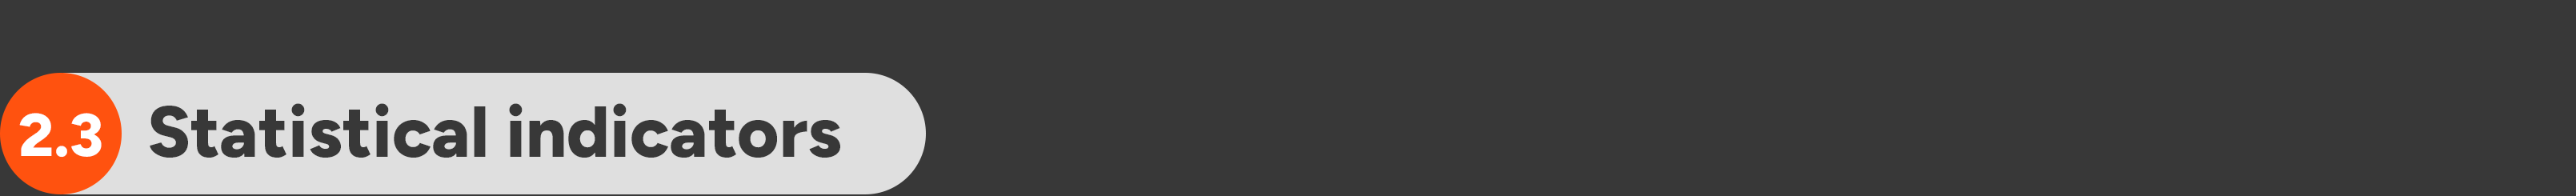

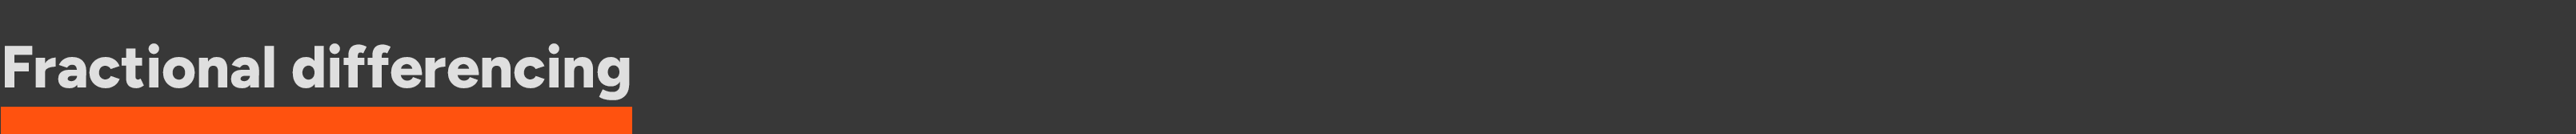

In [568]:
features_AUDCHF['frac_diff'] = frac_diff_price_df['AUDCHF']
features_AUDCHF

,sma_10,sma_20,ema_10,ema_20,volatility,rsi,macd,bb_upper,bb_middle,bb_lower,frac_diff
Date,,,,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2013-03-21,NaN,NaN,NaN,NaN,0.008470,NaN,NaN,0.0,NaN,0.0,NaN
2013-03-22,NaN,NaN,NaN,NaN,0.006947,NaN,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.034355,0.031631,0.034542,0.032610,0.167000,61.991346,0.000540,0.0,0.031631,0.0,0.020757
2024-05-03,0.035421,0.031691,0.035083,0.033078,0.165344,63.086686,0.000511,0.0,0.031691,0.0,0.020986
2024-05-05,0.036320,0.031873,0.035657,0.033569,0.163699,64.301826,0.000495,0.0,0.031873,0.0,0.021185


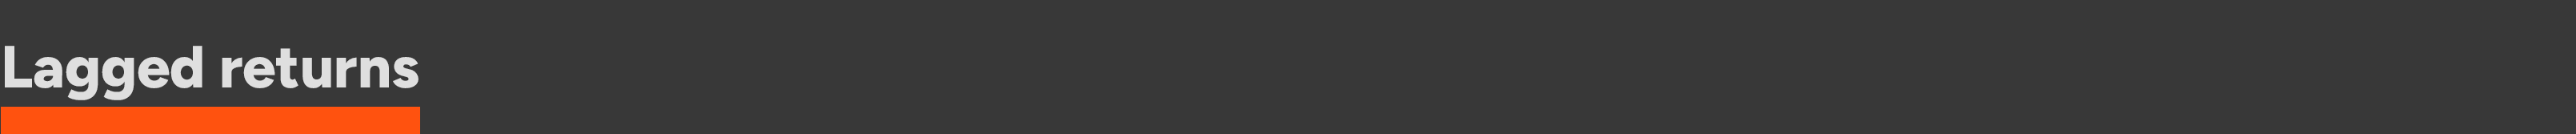

The approach of using lagged returns, and more generally past realizations of the price signal, as input for a RNN follows the recent work of Fischer and Krauss (2018), who find it to deliver highly accurate forecasts. We acknowledge that different ways to set up the forecasting tasks are possible and could consist of using technical indicators as additional signal and/or incorporating price signals from other financial instruments (e.g., other exchange rates than the one being forecast), among others

We use the time series of scaled returns as the sole feature, with the input at time t consisting of the sequence of returns of the previous trading days: https://link.springer.com/article/10.1007/s42521-020-00019-x

In [569]:
def create_lagged_features(data, pair, lag):
    df = data[[pair]].copy()
    for i in range(1, lag + 1):
        df[f'price_lag_{i}'] = df[pair].shift(i)
    return df

lagged_features = create_lagged_features(forex_daily_log_frdiff, 'AUDCHF', lag=5) 
lagged_features

,AUDCHF,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5
Date,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-21,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-05-02,0.020757,0.020754,0.018552,0.021970,0.022230,0.022728
2024-05-03,0.020986,0.020757,0.020754,0.018552,0.021970,0.022230
2024-05-05,0.021185,0.020986,0.020757,0.020754,0.018552,0.021970


In [584]:
features_AUDCHF = features_AUDCHF.merge(lagged_features.iloc[:, 1:], how='inner', left_index=True, right_index=True)
features_AUDCHF.tail(3)

,sma_10,sma_20,ema_10,ema_20,volatility,rsi,macd,bb_upper,bb_middle,bb_lower,...,price_lag_1_y,price_lag_2_y,price_lag_3_y,price_lag_4_y,price_lag_5_y,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-05,0.036320,0.031873,0.035657,0.033569,0.163699,64.301826,0.000495,0.0,0.031873,0.0,...,0.020986,0.020757,0.020754,0.018552,0.021970,0.020986,0.020757,0.020754,0.018552,0.021970
2024-05-06,0.036901,0.032221,0.036319,0.034115,0.162107,66.056267,0.000507,0.0,0.032221,0.0,...,0.021185,0.020986,0.020757,0.020754,0.018552,0.021185,0.020986,0.020757,0.020754,0.018552
2024-05-07,0.037370,0.032636,0.036854,0.034605,0.160495,65.953047,0.000465,0.0,0.032636,0.0,...,0.021664,0.021185,0.020986,0.020757,0.020754,0.021664,0.021185,0.020986,0.020757,0.020754


In [587]:
from datetime import datetime
import yfinance as yf

vix_symbol = '^VIX'

start_date = '2013-03-18' 
end_date = '2024-05-07'   

vix_data = yf.download(vix_symbol, start=start_date, end=end_date)

vix_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-18,13.47,13.64,12.57,13.36,13.36,0
2013-03-19,13.03,15.40,12.92,14.39,14.39,0
2013-03-20,13.18,13.18,12.30,12.67,12.67,0
2013-03-21,13.07,14.21,12.62,13.99,13.99,0
2013-03-22,13.34,13.85,13.19,13.57,13.57,0


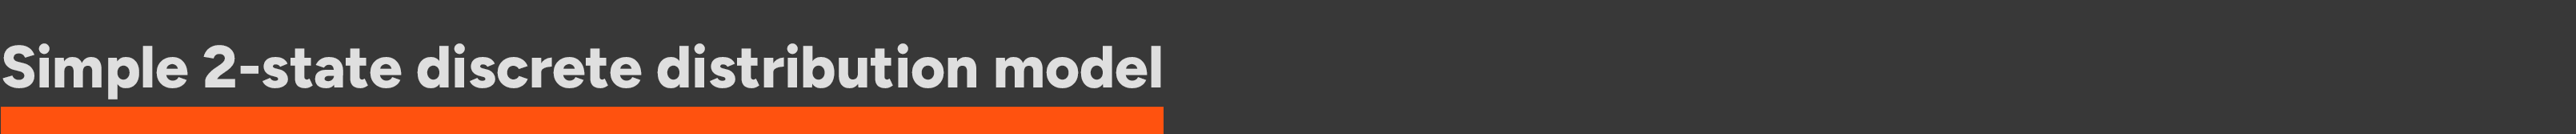

Why

When
 dealing with regime shifts, we expect Markov
 switching models to perform better than simple
 data partitions based on thresholds. For example,
 in Figure 1, if we had simply classified the observa
 tions that were in the highest quartile as being
 associated with Regime 2 (the high-mean regime),
 we would have misidentified the actual regime 40
 times out of 200 observations. In contrast, a well
 calibrated Markov-switching model would have
 misidentified the actual regime only three times.
 Arbitrary thresholds give false signals because they
 fail to capture the persistence in regimes as well as
 changing volatilities. For example, because Regime
 2 has higher volatility, a large negative value is
 most likely to come from this regime, even though
 it has a higher mean. Likewise, if the previous
 observation were volatile, the current observation
 would be more likely associated with Regime 2,
 even though a simple threshold might classify it as
 part of the quiet regime. Markov-switching models
 are designed to capture these features of the data.

To do
1. Define regimes
2. Create transitn matrix and calibrate initial and trans probability
3. Simulate

2 state assumption

we assumed that observations from Regime 1 were normally distributed with a given mean and stan dard deviation and that observations from Regime 2 were normally distributed with a different mean and standard deviation. Sev

**Types of Regime Switching Models**
1. Markov Switching Autoregressive Model (MS-AR)

2. Markov Switching Vector Autoregressive Model (MS-VAR)

3. Markov Switching GARCH Model (MS-GARCH)

**Estimation**
1. Maximum Likelihood Estimation (MLE)

* most common
2. Expectation-Maximisation (EM)
* E: algorithm calculates the expected value of the complete data log-likelihood, given the observed data and current parameter estimates (State Probabilities & Expected Log-Likelihood)
* M: maximises the expected log-likelihood obtained from the E-step; Update / re-estimate the parameters (e.g., transition probabilities, state-specific means, and variances) to maximise the expected log-likelihood. Iterate until the changes in parameter estimates are sufficiently small, indicating convergence.

3. Baum-Welch algorithm
* specific instance of the EM algorithm (#2) used for Hidden Markov Models (HMMs)

**THIS ONE = BAUM WELCH; two state model governed by simple discrete distribution**


https://github.com/tianyu-z/Kritzman-Regime-Detection/tree/master

https://scikit-learn.sourceforge.net/stable/modules/hmm.html

In [521]:
def hmm_model(data, pair, num_states = 2, n_iter = 100):

    price_series = data[[pair]]
    model = hmm.GaussianHMM(n_components=num_states, n_iter=100)

    model.fit(price_series)

    state_probabilities = model.predict_proba(price_series.values.reshape(-1, 1))

    hidden_states = model.predict(price_series.values.reshape(-1, 1))

    df = pd.DataFrame({
        'date': price_series.index,              
        'close': price_series.values.flatten(),  
        'hidden_state': hidden_states,
        'prob_state_0': state_probabilities[:, 0],
        'prob_state_1': state_probabilities[:, 1],
    })

    return df

,date,close,hidden_state,prob_state_0,prob_state_1
0,2013-03-18,0.353764,1,1.571799e-102,1.000000e+00
1,2013-03-19,0.351979,1,4.818332e-15,1.000000e+00
2,2013-03-20,0.351938,1,4.842319e-15,1.000000e+00
3,2013-03-21,0.354382,1,3.576916e-15,1.000000e+00
4,2013-03-22,0.354421,1,3.559478e-15,1.000000e+00
...,...,...,...,...,...
3440,2024-05-02,0.036857,0,1.000000e+00,3.446454e-08
3441,2024-05-03,0.037517,0,1.000000e+00,3.525484e-08
3442,2024-05-05,0.038241,0,1.000000e+00,4.180635e-08
3443,2024-05-06,0.039296,0,9.999996e-01,4.065040e-07


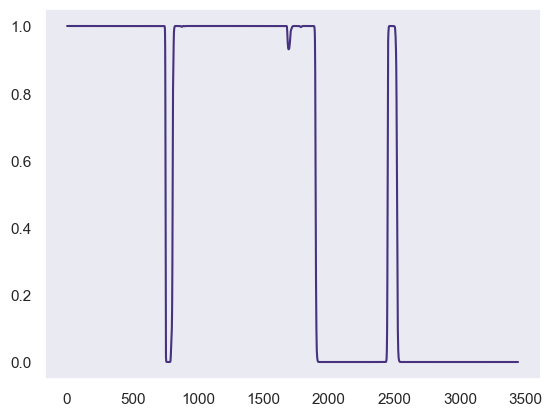

In [572]:
df2 = hmm_model(forex_daily_log, 'AUDCHF', num_states = 2, n_iter = 100)
df2['prob_state_1'].plot()  
df2

<div class="alert alert-danger">
<b>MUST DATA BE PRE-FRACDIFF TRANSFORMED?? cos after fracdiff -> all probs = 0</b>
</div>

Model is not converging.  Current: 12822.794639032078 is not greater than 12822.979524722097. Delta is -0.18488569001965516


<Axes: >

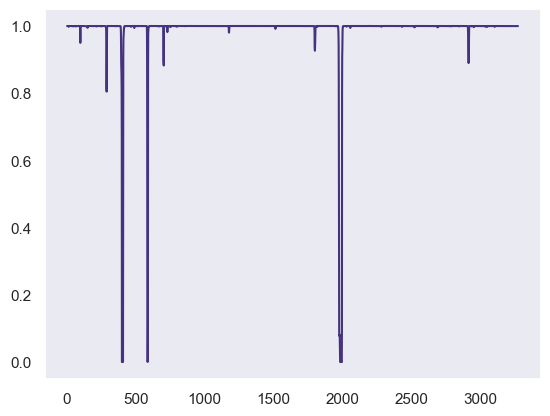

In [523]:
df3 = hmm_model(forex_daily_log_frdiff, 'AUDCHF', num_states = 2, n_iter = 100)
df3['prob_state_1'].plot()  

In [573]:
features_AUDCHF['prob_state_0'] = df2.loc[:, 'prob_state_0'].values
features_AUDCHF['prob_state_1'] = df2.loc[:, 'prob_state_1'].values
features_AUDCHF

,sma_10,sma_20,ema_10,ema_20,volatility,rsi,macd,bb_upper,bb_middle,bb_lower,frac_diff,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,prob_state_0,prob_state_1
Date,,,,,,,,,,,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.571799e-102,1.000000e+00
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.818332e-15,1.000000e+00
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.842319e-15,1.000000e+00
2013-03-21,NaN,NaN,NaN,NaN,0.008470,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.576916e-15,1.000000e+00
2013-03-22,NaN,NaN,NaN,NaN,0.006947,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.559478e-15,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.034355,0.031631,0.034542,0.032610,0.167000,61.991346,0.000540,0.0,0.031631,0.0,0.020757,0.020754,0.018552,0.021970,0.022230,0.022728,1.000000e+00,3.446454e-08
2024-05-03,0.035421,0.031691,0.035083,0.033078,0.165344,63.086686,0.000511,0.0,0.031691,0.0,0.020986,0.020757,0.020754,0.018552,0.021970,0.022230,1.000000e+00,3.525484e-08
2024-05-05,0.036320,0.031873,0.035657,0.033569,0.163699,64.301826,0.000495,0.0,0.031873,0.0,0.021185,0.020986,0.020757,0.020754,0.018552,0.021970,1.000000e+00,4.180635e-08


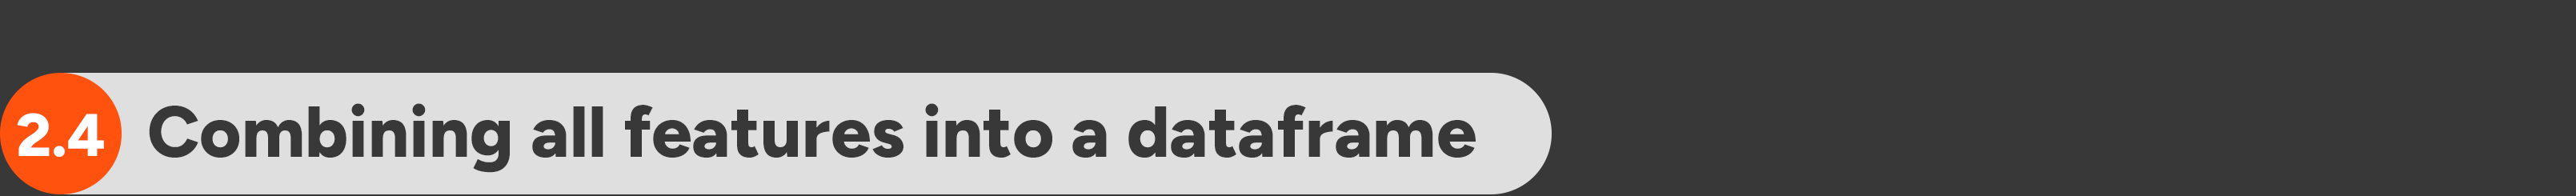

<div class="alert alert-success">
<b>KEY DATAFRAME: forex_daily_log_frdiff</b>
</div>

In [579]:
for pair in forex_daily_log_frdiff.columns:
    features = pd.DataFrame()
    price = forex_daily_log[pair]

    # technical indicators
    features['sma_10'] = ta.trend.sma_indicator(price, window=10)
    features['sma_20'] = ta.trend.sma_indicator(price, window=20)
    features['ema_10'] = ta.trend.ema_indicator(price, window=10)
    features['ema_20'] = ta.trend.ema_indicator(price, window=20)
    features['volatility'] = daily_volatility_with_log_returns(price, 100)

    # statistical indicators
    features['frac_diff'] = frac_diff_price_df[pair]
    hmm_result_df = hmm_model(forex_daily_log, pair, num_states = 2, n_iter = 100)
    # used log not frdiff price here???????
    features['prob_state_0'] = hmm_result_df.loc[:, 'prob_state_0'].values
    features['prob_state_1'] = hmm_result_df.loc[:, 'prob_state_1'].values

    features['rsi'] = ta.momentum.rsi(price)
    features['macd'] = ta.trend.macd_diff(price)
    features['bb_upper'] = ta.volatility.bollinger_hband(price)
    features['bb_middle'] = ta.volatility.bollinger_mavg(price)
    features['bb_lower'] = ta.volatility.bollinger_lband(price)

    # fundamental indicators

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [581]:
features

,sma_10,sma_20,ema_10,ema_20,volatility,frac_diff,prob_state_0,prob_state_1,rsi,macd,bb_upper,bb_middle,bb_lower
Date,,,,,,,,,,,,,
2013-03-18,NaN,NaN,NaN,NaN,NaN,NaN,2.421439e-179,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-19,NaN,NaN,NaN,NaN,NaN,NaN,7.311754e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-20,NaN,NaN,NaN,NaN,NaN,NaN,8.069324e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-21,NaN,NaN,NaN,NaN,0.001484,NaN,5.112590e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN,NaN,0.001088,NaN,6.536129e-18,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,3.314640,3.337436,3.314119,3.317087,0.005756,0.753114,6.035647e-15,1.0,43.239625,-0.010781,3.388318,3.337436,3.286554
2024-05-03,3.310602,3.334702,3.310546,3.314932,0.005699,0.772505,6.180146e-15,1.0,43.127432,-0.010288,3.388562,3.334702,3.280842
2024-05-05,3.308678,3.332006,3.307869,3.313113,0.005642,0.839130,5.578771e-15,1.0,43.806410,-0.009468,3.387943,3.332006,3.276069


<Axes: xlabel='Date'>

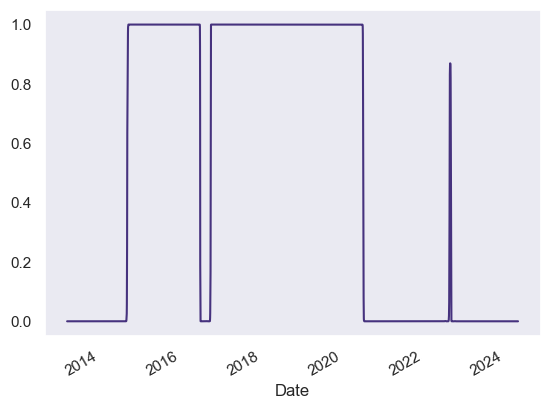

In [580]:
features['prob_state_0'].plot()

drop na

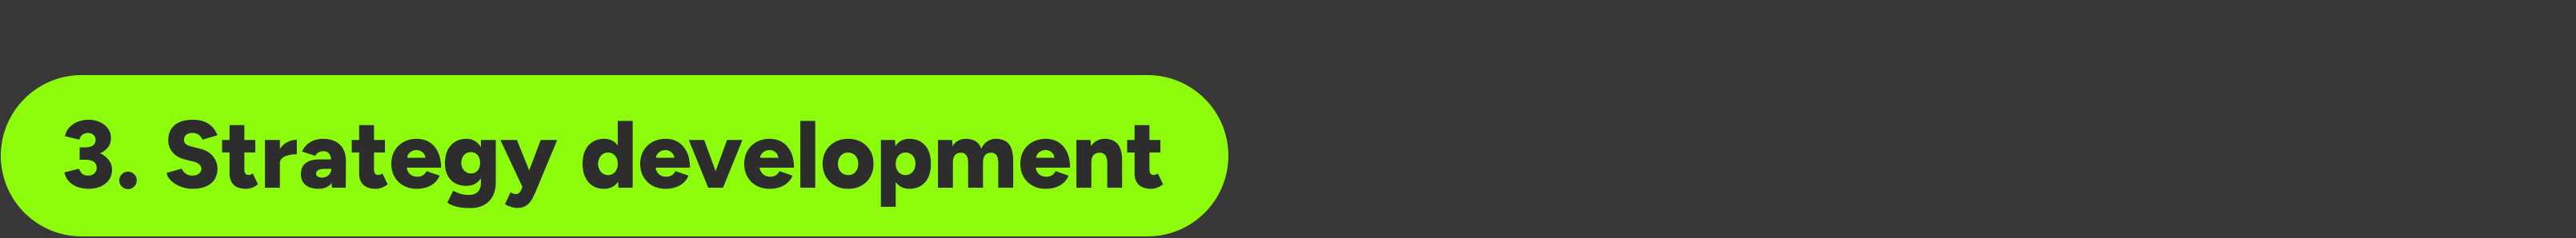

Simplest strat: classic moving average crossover type.

At every bar calculate the 10-day and 30-day simple moving averages (SMA)

If the 10-day SMA exceeds the 30-day SMA and the strategy is not invested, then go long

If the 30-day SMA exceeds the 10-day SMA and the strategy is invested, then close the position

https://arxiv.org/pdf/2009.10065

file:///C:/Users/kalul/Downloads/Dataselectionpairsavoidoverfitting.pdf


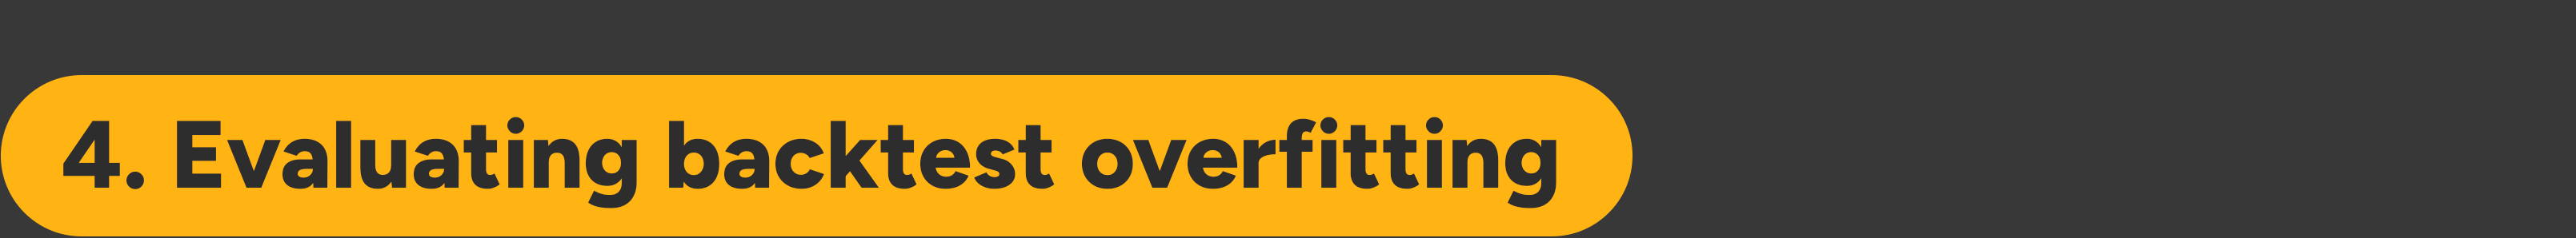